## Credit Card Fraud

Data Has been sourced from Kaggle

Get the real data from : https://drive.google.com/file/d/1r1TU_hPn_SQwhElDE47ObdPAkDTOMkFO/view?usp=sharing


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Our task is to make a simple DL classifer to correctly classify frauds.

In [ ]:
# Starting with useful imports
import csv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%ls
!pwd

drive/  sample_data/
/content


In [ ]:
fname = '/content/drive/MyDrive/Colab Notebooks/creditcard.csv'
all_features = []
all_targets = []
with open(fname) as f:
  for i, line in enumerate(f):
    if i == 0:
      print('HEADER:', line.strip())
      continue  # Skip header
    fields = line.strip().split(',')
    all_features.append([float(v.replace('"', '')) for v in fields[:-1]]) #X data
    all_targets.append([int(fields[-1].replace('"', ''))]) # y data
    if i == 1:
      print('EXAMPLE FEATURES:', all_features[-1])
    
features = np.array(all_features, dtype='float32')
targets = np.array(all_targets, dtype='uint8')
print('features.shape:', features.shape)
print('targets.shape:', targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


In [ ]:
num_test_samples = int(len(features) * 0.2) 
train_features = features[:-num_test_samples]
train_targets = targets[:-num_test_samples]
test_features = features[-num_test_samples:]
test_targets = targets[-num_test_samples:]
print('Number of training samples:', len(train_features))
print('Number of test samples:', len(test_features))

Number of training samples: 227846
Number of test samples: 56961


In [ ]:
counts = np.bincount(train_targets[:, 0])
print('Number of positive samples in training data: {} ({:.2f}% of total)'.format(counts[1], 100 * float(counts[1]) / len(train_targets)))

Number of positive samples in training data: 417 (0.18% of total)


In [ ]:
counts = np.bincount(test_targets[:, 0])
print('Number of positive samples in testing data: {} ({:.2f}% of total)'.format(counts[1], 100 * float(counts[1]) / len(test_targets)))

Number of positive samples in testing data: 75 (0.13% of total)


In [ ]:
###MY IMPLEMENTATION:

In [ ]:
#Dealing with imbalance data by performing undersampling

from imblearn.under_sampling import RandomUnderSampler

random_under_sampler = RandomUnderSampler(random_state=42, replacement=True)
# generating fit predictor and target variable
x_random_under_sampler, y_random_under_sampler = random_under_sampler.fit_resample(train_features , train_targets)

print('original dataset shape:{} ({:.2f}% of total)'.format(counts[1], 100 * float(counts[1]) / len(train_targets)))
new_counts = np.bincount(y_random_under_sampler)
print('Resample dataset shape{} ({:.2f}% of total)'.format(new_counts[1], 100 * float(new_counts[1]) / len(y_random_under_sampler)))

original dataset shape:75 (0.03% of total)
Resample dataset shape417 (50.00% of total)


In [ ]:
#scaling (z distribution calculation)
mean = np.mean(x_random_under_sampler, axis=0)
x_random_under_sampler -= mean
test_features -= mean
std = np.std(x_random_under_sampler, axis=0)
x_random_under_sampler /= std
test_features /= std


In [ ]:
x_random_under_sampler.shape

(834, 30)

In [ ]:
x_random_under_sampler

array([[ 0.05793848,  0.29947796, -0.26536214, ..., -0.16868913,
        -0.08183001, -0.3667223 ],
       [ 0.35106084,  0.39907467, -0.48019305, ..., -0.23779082,
        -0.32756114,  0.10228179],
       [ 0.1435264 ,  0.44773677, -0.8012747 , ..., -0.08816357,
        -0.26607385, -0.34495324],
       ...,
       [ 1.7351662 ,  0.1276837 ,  0.4271164 , ...,  0.35209394,
        -0.18614782, -0.42685652],
       [ 1.7690208 ,  0.05937538,  0.23369019, ...,  0.38407382,
        -1.1346563 ,  2.4464397 ],
       [ 1.769797  , -0.6291648 , -0.10559474, ...,  0.6293404 ,
        -1.717035  , -0.43116722]], dtype=float32)

In [ ]:
# NN training
from tensorflow import keras
import tensorflow as tf
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

model = Sequential()                  
model.add(Dense(40, input_dim=30, activation= 'tanh', kernel_regularizer='L2' ))
model.add(Dense(20, activation= 'relu', kernel_regularizer='L2'))
model.add(Dropout(0.25))
model.add(Dense(10,activation= 'relu', kernel_regularizer='L2'))
model.add(Dense(5, activation= 'relu'))
model.add(Dense(1))   #by default using softmax activation function
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' )
model.summary()
history = model.fit(x_random_under_sampler, y_random_under_sampler, validation_split= 0.1, epochs=100, batch_size=32, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 40)                1240      
                                                                 
 dense_36 (Dense)            (None, 20)                820       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dense_38 (Dense)            (None, 5)                 55        
                                                                 
 dense_39 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,331
Trainable params: 2,331
Non-traina

In [ ]:
# serialize model to JSON
model.save('credit_card_fraud_model')
print("Saved model to disk")

INFO:tensorflow:Assets written to: credit_card_fraud_model/assets
Saved model to disk


In [ ]:
reloaded_model = tf.keras.models.load_model('credit_card_fraud_model')

# Reviewing my model after reload
reloaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 40)                1240      
                                                                 
 dense_36 (Dense)            (None, 20)                820       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dense_38 (Dense)            (None, 5)                 55        
                                                                 
 dense_39 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,331
Trainable params: 2,331
Non-traina

In [ ]:
#defining function to generate the ypred binary output for classification report
def binary_inference(input_list, threshold=0.8):
  probability_list = []
  for i in input_list:
    if i>= threshold:
      probability_list.append(1)
    else:
      probability_list.append(0)

   
  return probability_list

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_features)
y_pred_binary = binary_inference(y_pred)
classification_report = classification_report(test_targets, y_pred_binary)
print(classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.20      0.76      0.32        75

    accuracy                           1.00     56961
   macro avg       0.60      0.88      0.66     56961
weighted avg       1.00      1.00      1.00     56961



Text(0, 0.5, 'Loss')

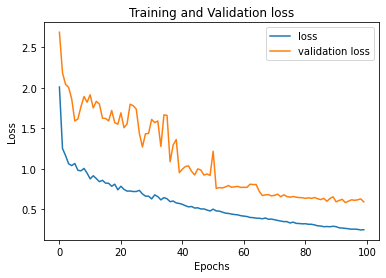

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['loss','validation loss'])
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
confusion_matrix = confusion_matrix(test_targets, y_pred_binary)

print(confusion_matrix)

[[56663   223]
 [   18    57]]


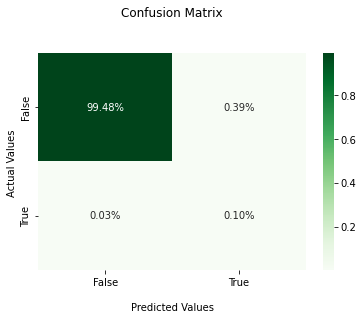

In [ ]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Greens')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
## PROBLEMS :
## NOT ABLE TO CALCULATE ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds_rf = roc_curve(y_test_randomSampler, y_predBinary)
auc = auc(fpr, tpr)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# end of my code

In [ ]:
#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
# metrics = [keras.metrics.FalseNegatives(name='fn'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.TrueNegatives(name='tn'),
#            keras.metrics.TruePositives(name='tp'),
#            keras.metrics.Precision(name='precision'),
#            keras.metrics.Recall(name='recall'),
#            keras.metrics.Accuracy(name='accuracy')]

# model.compile(optimizer=keras.optimizers.Adam(1e-2),
#               loss='binary_crossentropy',
#               metrics=metrics)

# #callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
# class_weight = {0: 1, 1: 200}

# model.fit(train_features, train_targets,
#           batch_size=4096, epochs=100, verbose=2, validation_data=(test_features, test_targets), class_weight=class_weight)

In [ ]:
# homework
# Solve the clasification problem. 
# handle data imbalance issue
# Design DL network to classify
# Print loss, F1 score and ROC
# Visualize loss in training and test data using matplotlib
# Send the link of colab to amritansh.48@gmail.com

# **Summary of Experiments:**

Went with Sequential for all the experiments
Dropout of 25% added after hidden layer 2

**Experiment 1:**

Hidden layer with neuron counts as 
40 - activation= 'tanh', kernel_regularizer='L2'
20 - activation= 'relu', kernel_regularizer='L2'
10 - activation= 'relu', kernel_regularizer='L2'
5 - activation= 'relu'
Output layer - loss= 'binary_crossentropy' , optimizer= 'adam'
validation_split= 0.1, epochs=100, batch_size=32

f1 score: f1 score: 55


**Experiment 2:**

Hidden layer with neuron counts as 
40 - activation= 'relu', kernel_regularizer='L2'
20 - activation= 'relu', kernel_regularizer='L2'
10 - activation= 'relu', kernel_regularizer='L2'
5 - activation= 'relu'
Output layer - loss= 'binary_crossentropy' , optimizer= 'adam'

validation_split= 0.1, epochs=200, batch_size=32

f1 score: 68


**Experiment 3:**

Hidden layer with neuron counts as 
40 - activation= 'relu', kernel_regularizer='L2'
20 - activation= 'relu', kernel_regularizer='L2'
10 - activation= 'relu', kernel_regularizer='L2'
5 - activation= 'relu'
Output layer - loss= 'binary_crossentropy' , optimizer= 'adam'

validation_split= 0.2, epochs=200, batch_size=32

f1 score:  0.77



**Experiment 4:**

Hidden layer with neuron counts as 
80 - activation= 'relu', kernel_regularizer='L2'
40 - activation= 'relu', kernel_regularizer='L2'
20 - activation= 'relu', kernel_regularizer='L2'
10 - activation= 'relu'
Output layer - loss= 'binary_crossentropy' , optimizer= 'adam'

validation_split= 0.2, epochs=200, batch_size=32

f1 score:  0.76